In [17]:
import torch
import torchvision
import torch.nn as nn

In [18]:
import random
import matplotlib.pyplot as plt

# 0. Use device to acclerate experiment time
# device = 'cpu'
device = 'cuda:0'

n = 32
N = 10000
# 1. 100 is not enough, 10000 should do the job

x_list = []
y_list = []

for i in range(N):
    x = torch.linspace(-1, 1, n)
    mode = random.randint(0, 1)
    if mode == 0:
        y = torch.linspace(-2, 2, n)
    else:
        y = torch.linspace(2, -2, n)
    
    noise_x = 0.02 * torch.randn(n)
    noise_y = 0.02 * torch.randn(n)
    x = x + noise_x
    y = y + noise_y
    x_list.append(x)
    y_list.append(y)

x = torch.stack(x_list)
y = torch.stack(y_list)

data = torch.stack((x, y), dim=1)
print(data.shape)


torch.Size([10000, 2, 32])


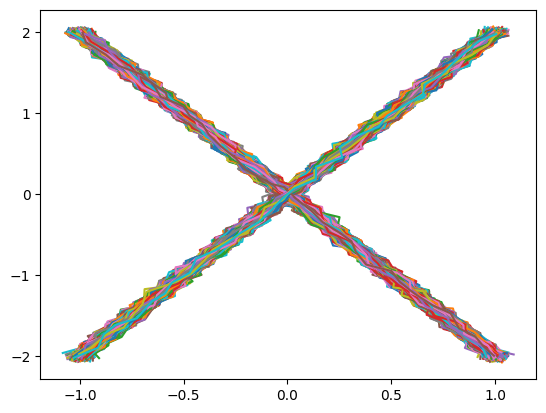

In [19]:
plt_data = data.cpu().numpy()
plt.plot(plt_data[:, 0, :].T, plt_data[:, 1, :].T);

In [20]:
data = data.to(device=device)

In [21]:
'''
Define a sequence of sigma_t's.
'''
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "constant":
        betas = torch.ones(n_timesteps) * start
    return betas

In [22]:
"""initialize diffusion-related constant"""
beta_schedule = 'linear'
n_timesteps = 1000
beta_start, beta_end = 1e-3, 1e-2
# beta_start, beta_end = 1e-4, 1e-3
betas = make_beta_schedule(
    schedule=beta_schedule,
    n_timesteps=n_timesteps,
    start=beta_start,
    end=beta_end,
).to(device=device)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float().to(device=device), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [23]:
"""Pytorch version of https://pasus.tistory.com/204"""

import torch.nn as nn

class ConvBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(ConvBlock, self).__init__()

    self.conv1 = nn.Conv1d(channels_1, channels_2, 3, padding='same')
    self.conv2 = nn.Conv1d(channels_2, channels_2, 3, padding='same')

    self.bn1 = nn.BatchNorm1d(channels_2)
    self.bn2 = nn.BatchNorm1d(channels_2)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    return x

class EncoderBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(EncoderBlock, self).__init__()

    self.conv_blk = ConvBlock(channels_1, channels_2)
    self.pool = nn.MaxPool1d(2)

  def forward(self, x):
    x = self.conv_blk(x)
    p = self.pool(x)
    return x, p

class DecoderBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(DecoderBlock, self).__init__()

    self.up = nn.ConvTranspose1d(channels_1, channels_2, 2, stride = 2)    # padding?
    self.conv_blk = ConvBlock(channels_1, channels_2)

  def forward(self, x, skip):
    x = self.up(x)
    x = torch.concat([x, skip], dim = 1)
    x = self.conv_blk(x)

    return x

class UNET(nn.Module):
  def __init__(self):
    super(UNET, self).__init__()

    self.e1 = EncoderBlock(2, 32)
    self.e2 = EncoderBlock(32, 64)

    self.b = ConvBlock(64, 128)

    self.d1 = DecoderBlock(128, 64)
    self.d2 = DecoderBlock(64, 32)

    self.outputs = nn.Conv1d(32, 2, 1)
    # self.activation = nn.ReLU()

  def forward(self, inputs, t):
    batch_size = inputs.size()[0]
    image_size_1 = inputs.size()[-2]
    image_size_2 = inputs.size()[-1]
    
    # s1, p1 = self.e1(inputs + time_embed(n_timesteps, 2, device=device)[:, :, t].transpose(-1, 0)) # time embed is used too redundantly -> Problem! print time_embed(n_timesteps, image_size_2)[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1)
    s1, p1 = self.e1(inputs) 
    s2, p2 = self.e2(p1 + time_embed(n_timesteps, 32, device=device)[:, :, t].transpose(-1, 0)) # Why are you dividing with /2?
    # 5. The variables in time_embed should be switched (I think...) -> Then why does this code work?
    # 6. It would be better (or easier) to give time variable to Encoder, Decoder block instead of adding it explicitly to the network.

    b = self.b(p2 + time_embed(n_timesteps, 64, device=device)[:, :, t].transpose(-1, 0))

    d1 = self.d1(b + time_embed(n_timesteps, 128, device=device)[:, :, t].transpose(-1, 0), s2)
    d2 = self.d2(d1 + time_embed(n_timesteps, 64, device=device)[:, :, t].transpose(-1, 0), s1)

    outputs = self.outputs(d2)

    return outputs

In [24]:
from positional_encodings.torch_encodings import PositionalEncoding3D, PositionalEncoding1D

#3. I think this version is better
def time_embed(time_length, feature_dim, device='cpu'):
  pos_encoder = PositionalEncoding1D(feature_dim)
  z = torch.zeros(1, time_length, feature_dim)
  return pos_encoder(z).transpose(-2, -1).to(device=device)

In [25]:
eps_network = UNET().to(device=device)
eps_network.load_state_dict(torch.load('./Epsilon Tracking Data/Trajectory Diffusion 0118'))
eps_network.eval();

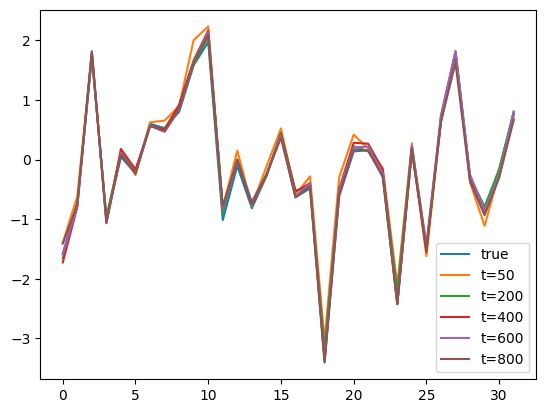

In [26]:
x = range(n)

data_tmp = data[0, :, :].unsqueeze(0)
eps = torch.randn(1, 2, n, device=device)
plt.plot(x, eps[0, 1, :].cpu().numpy())

for i in range(5):
    t = 200 * i
    if i == 0:
        t = 50
    input = alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * data_tmp + one_minus_alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * eps
    eps_est = eps_network(input, t)
    plt.plot(x, eps_est[0, 1, :].detach().cpu().numpy())
    
plt.legend(['true', 't=50', 't=200', 't=400', 't=600', 't=800']);

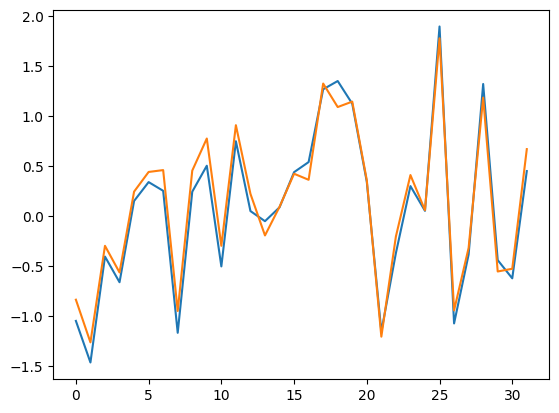

In [27]:
x = range(n)

data_tmp = data[0, :, :].unsqueeze(0)
eps = torch.randn(1, 2, n, device=device)
plt.plot(x, eps[0, 1, :].cpu().numpy())

for i in range(1):
    t = 999
    if i == 0:
        t = 50
    input = alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * data_tmp + one_minus_alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * eps
    eps_est = eps_network(input, t)
    plt.plot(x, eps_est[0, 1, :].detach().cpu().numpy())
    
# plt.legend(['true', 't=50', 't=200', 't=400', 't=600', 't=800']);

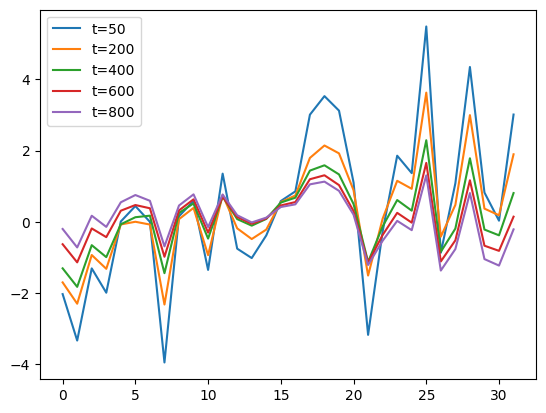

In [28]:
x = range(n)

data_tmp = data[0, :, :].unsqueeze(0)
input = alphas_bar_sqrt[500].unsqueeze(-1).unsqueeze(-1) * data_tmp + one_minus_alphas_bar_sqrt[500].unsqueeze(-1).unsqueeze(-1) * eps

for i in range(5):
    t = 200 * i
    if i == 0:
        t = 50
    eps_est = eps_network(input, t)
    plt.plot(x, eps_est[0, 1, :].detach().cpu().numpy())
    
plt.legend(['t=50', 't=200', 't=400', 't=600', 't=800']);